In [1]:
#import
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import RegressorChain
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Perceptron

C:\Users\NotOte\AppData\Local\Temp\ipykernel_10364\1818141246.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def mape(y_true, y_pred):
  return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

In [3]:
# Predict the next time step using a sequence of past observations

def window_input(window_length: int, data: pd.DataFrame, apple: str) -> pd.DataFrame:
    df = data.copy()
    i = 1
    while i < window_length:
      df[f'x_{i}'] = df[apple].shift(-i)
      i += 1

    if i == window_length:
      df['y'] = df[apple].shift(-i)

    df = df.dropna(axis=0)
    return df

In [4]:
# Predict a sequence of future time steps using a sequence of past observations

def window_input_output(input_length: int, output_length: int, data: pd.DataFrame, apple: str) -> pd.DataFrame:
    df = data.copy()
    i = 1
    while i < input_length:
      df[f'x_{i}'] = df[apple].shift(-i)
      i += 1

    j = 0
    while j < output_length:
      df[f'y_{j}'] = df[apple].shift(-output_length-j)
      j += 1

    df = df.dropna(axis=0)
    return df

In [5]:
def _plot_series(series, series_name, apple, theme):
  xs = series['Date']
  ys = series[apple]
  plt.plot(xs, ys, label=series_name, color=list(sns.palettes.mpl_palette(theme))[0])

In [6]:
# อ่านข้อมูล เลือกประเทศ Africa
df = pd.read_csv('dataset/Apple462.csv')
df = df[df["region"] == "Africa"]
# แสดงข้อมูล
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 169 entries, 572 to 3440
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  169 non-null    int64  
 1   Date        169 non-null    object 
 2   Envi        163 non-null    float64
 3   Fuji        163 non-null    float64
 4   Gala        168 non-null    float64
 5   region      169 non-null    object 
dtypes: float64(3), int64(1), object(2)
memory usage: 9.2+ KB


In [7]:
df

,Unnamed: 0,Date,Envi,Fuji,Gala,region
572,0,27/12/2015,494426.0,276557.0,84913.0,Africa
573,1,20/12/2015,NaN,257532.0,91158.0,Africa
574,2,13/12/2015,476179.0,319790.0,62437.0,Africa
575,3,6/12/2015,514160.0,412692.0,8533.0,Africa
576,4,29/11/2015,477944.0,244880.0,6212.0,Africa
...,...,...,...,...,...,...
3436,7,4/2/2018,855815.0,340887.0,6655.0,Africa
3437,8,28/1/2018,781165.0,187034.0,5597.0,Africa
3438,9,21/1/2018,728035.0,216212.0,6292.0,Africa
3439,10,14/1/2018,677478.0,316020.0,7862.0,Africa


# Envi apple data

## Data preprocessing

In [8]:
# เลือกวันที่และ apple พันธุ์ Envi
envi_data = df.loc[:, ['Date', 'Envi']]
# เติมช่องที่ขาดหายไปด้วย interpolation
envi_data = envi_data.interpolate()
# เปลี่ยน format ของ date จาก string เป็น datetime
envi_data['Date'] = pd.to_datetime(envi_data['Date'], format='%d/%m/%Y')
envi_data.sort_values('Date', inplace = True)
envi_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 169 entries, 623 to 3429
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    169 non-null    datetime64[ns]
 1   Envi    169 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.0 KB


C:\Users\NotOte\AppData\Local\Temp\ipykernel_10364\128418739.py:4: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  envi_data = envi_data.interpolate()


In [9]:
envi_data

,Date,Envi
623,2015-01-04,612796.0
622,2015-01-11,680572.0
621,2015-01-18,627091.0
620,2015-01-25,649344.0
619,2015-02-01,786167.0
...,...,...
3433,2018-02-25,807934.0
3432,2018-03-04,673535.0
3431,2018-03-11,665189.0
3430,2018-03-18,656843.0


## Visualize data

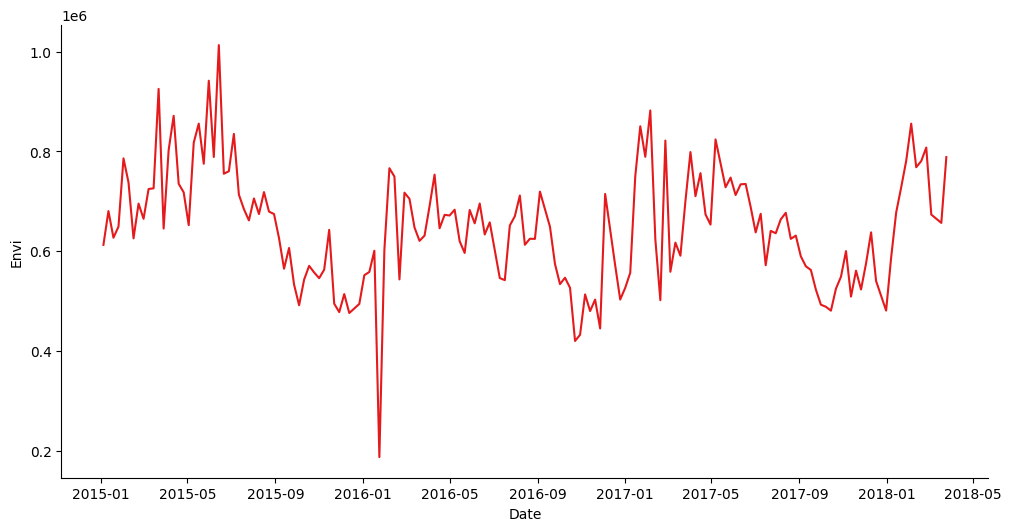

In [10]:
fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = envi_data.sort_values('Date', ascending=True)
_plot_series(df_sorted,'','Envi', 'Set1')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('Envi')

## Predict the next time step using a sequence of past observations

In [11]:
envi = window_input(5, envi_data, 'Envi')
envi

,Date,Envi,x_1,x_2,x_3,x_4,y
623,2015-01-04,612796.0,680572.0,627091.0,649344.0,786167.0,737969.0
622,2015-01-11,680572.0,627091.0,649344.0,786167.0,737969.0,625814.0
621,2015-01-18,627091.0,649344.0,786167.0,737969.0,625814.0,695493.0
620,2015-01-25,649344.0,786167.0,737969.0,625814.0,695493.0,665033.0
619,2015-02-01,786167.0,737969.0,625814.0,695493.0,665033.0,724776.0
...,...,...,...,...,...,...,...
3438,2018-01-21,728035.0,781165.0,855815.0,768416.0,780856.0,807934.0
3437,2018-01-28,781165.0,855815.0,768416.0,780856.0,807934.0,673535.0
3436,2018-02-04,855815.0,768416.0,780856.0,807934.0,673535.0,665189.0
3435,2018-02-11,768416.0,780856.0,807934.0,673535.0,665189.0,656843.0


In [12]:
# X_cols คือ columns ที่มี x_?
X_cols = [col for col in envi.columns if col.startswith('x')]
# เพิ่ม Envi
X_cols.insert(0, 'Envi')

# X = features and y = labels
X = envi[X_cols].values
y = envi['y'].values

# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

In [13]:
# baseline_pred คือ เอาทุก x มาหา mean
baseline_pred = np.array([np.mean(row) for row in X_test])

### Training

#### Decision Tree Regressor

In [14]:
dt_reg = DecisionTreeRegressor(random_state=42, max_depth=3)
dt_reg.fit(X_train, y_train)
dt_pred = dt_reg.predict(X_test)

#### Gredient boosting

In [15]:
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train.ravel())
gbr_pred = gbr.predict(X_test)

#### Random forest

In [16]:
rand_forest_regr = RandomForestRegressor(max_depth=2, random_state=42)
rand_forest_regr.fit(X_train, y_train)
rand_forest_regr_pred = rand_forest_regr.predict(X_test)

#### Multilayer Perceptron (Neural Network)

In [17]:
mlp_regr = MLPRegressor(random_state=1,
                        early_stopping=True,
                        learning_rate_init=0.01).fit(X_train, y_train)
mlp_pred = mlp_regr.predict(X_test)

### Visualize Prediction

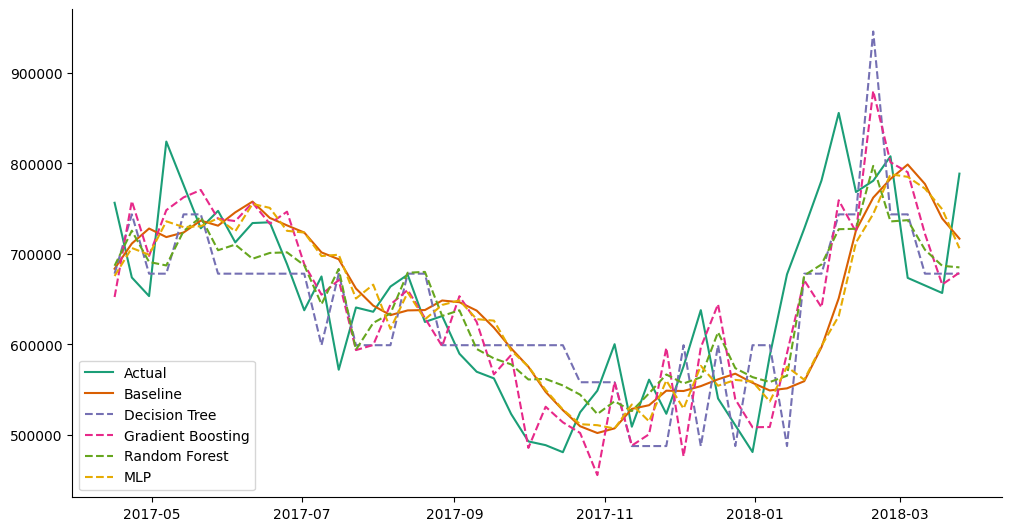

In [18]:
fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')

date = envi_data['Date'][119:170]

plt.plot(date, y_test, label='Actual', color=list(sns.palettes.mpl_palette('Dark2'))[0])
plt.plot(date, baseline_pred, label='Baseline', color=list(sns.palettes.mpl_palette('Dark2'))[1])
plt.plot(date, dt_pred, label='Decision Tree', linestyle='dashed', color=list(sns.palettes.mpl_palette('Dark2'))[2])
plt.plot(date, gbr_pred, label='Gradient Boosting', linestyle='dashed', color=list(sns.palettes.mpl_palette('Dark2'))[3])
plt.plot(date, rand_forest_regr_pred, label='Random Forest', linestyle='dashed', color=list(sns.palettes.mpl_palette('Dark2'))[4])
plt.plot(date, mlp_pred, label='MLP', linestyle='dashed', color=list(sns.palettes.mpl_palette('Dark2'))[5])
plt.legend()

sns.despine(fig=fig, ax=ax)

### Evaluating (MAPE)

In [19]:
baseline_mape = mape(y_test, baseline_pred)
dt_mape = mape(y_test, dt_pred)
gbr_mape = mape(y_test, gbr_pred)
mlp_mape = mape(y_test, mlp_pred)
rand_forest_mape = mape(y_test, rand_forest_regr_pred)

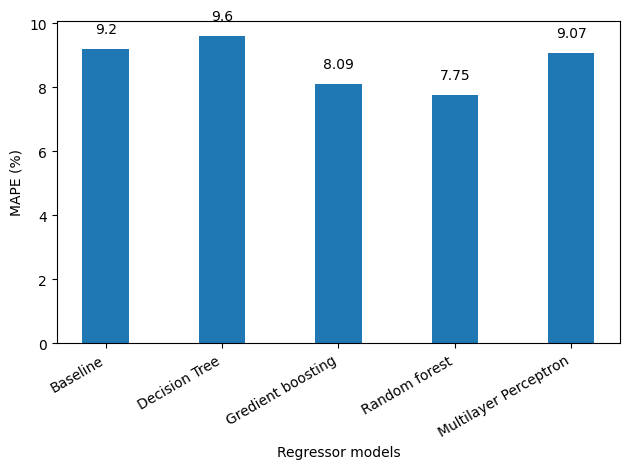

In [20]:
x = ['Baseline', 'Decision Tree', 'Gredient boosting', 'Random forest', 'Multilayer Perceptron']
y = [baseline_mape, dt_mape, gbr_mape, rand_forest_mape, mlp_mape]

fig, ax = plt.subplots()

fig.autofmt_xdate()

ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('MAPE (%)')

for index, value in enumerate(y):
  plt.text(x=index, y=value + 0.5, s=str(value), ha='center')

plt.tight_layout()

## Predict a sequence of future time steps using a sequence of past observations

In [21]:
# เติม x, y ใน envi
envi = window_input_output(5, 5, envi_data, 'Envi')
envi

,Date,Envi,x_1,x_2,x_3,x_4,y_0,y_1,y_2,y_3,y_4
623,2015-01-04,612796.0,680572.0,627091.0,649344.0,786167.0,737969.0,625814.0,695493.0,665033.0,724776.0
622,2015-01-11,680572.0,627091.0,649344.0,786167.0,737969.0,625814.0,695493.0,665033.0,724776.0,726176.0
621,2015-01-18,627091.0,649344.0,786167.0,737969.0,625814.0,695493.0,665033.0,724776.0,726176.0,925527.0
620,2015-01-25,649344.0,786167.0,737969.0,625814.0,695493.0,665033.0,724776.0,726176.0,925527.0,645523.0
619,2015-02-01,786167.0,737969.0,625814.0,695493.0,665033.0,724776.0,726176.0,925527.0,645523.0,802918.0
...,...,...,...,...,...,...,...,...,...,...,...
2768,2017-12-24,510678.5,481105.0,587440.0,677478.0,728035.0,781165.0,855815.0,768416.0,780856.0,807934.0
2767,2017-12-31,481105.0,587440.0,677478.0,728035.0,781165.0,855815.0,768416.0,780856.0,807934.0,673535.0
3440,2018-01-07,587440.0,677478.0,728035.0,781165.0,855815.0,768416.0,780856.0,807934.0,673535.0,665189.0
3439,2018-01-14,677478.0,728035.0,781165.0,855815.0,768416.0,780856.0,807934.0,673535.0,665189.0,656843.0


In [22]:
# X_cols คือ columns ที่มี x_?
X_cols = [col for col in envi.columns if col.startswith('x')]
# เพิ่ม Envi
X_cols.insert(0, 'Envi')

# X_cols คือ columns ที่มี y_?
y_cols = [col for col in envi.columns if col.startswith('y')]

# X = features and y = labels
X = envi[X_cols].values
y = envi[y_cols].values

# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

### Training

#### Decision Tree Regressor

In [23]:
dt_reg = DecisionTreeRegressor(random_state=42)
dt_reg.fit(X_train, y_train)
dt_pred = dt_reg.predict(X_test)

#### Gradient boosting (regressor chain)

In [24]:
gbr = GradientBoostingRegressor(random_state=42)
chained_gbr = RegressorChain(gbr)
chained_gbr.fit(X_train, y_train)
gbr_seq_preds = chained_gbr.predict(X_test)

#### Multilayer Perceptron (Neural Network)

In [25]:
mlp_regr = MLPRegressor(random_state=1, max_iter=1000, solver='adam', early_stopping=True, learning_rate_init=0.01).fit(X_train, y_train)
mlp_pred = mlp_regr.predict(X_test)

#### Random forest

In [26]:
rand_forest_regr = RandomForestRegressor(max_depth=5, random_state=42)
rand_forest_regr.fit(X_train, y_train)
rand_forest_regr_pred = rand_forest_regr.predict(X_test)

### Evaluating (MAPE)

In [27]:
baseline_mape = mape(X_test.reshape(1, -1), y_test.reshape(1, -1))
dt_mape = mape(y_test.reshape(1, -1), dt_pred.reshape(1, -1))
mlp_mape = mape(y_test.reshape(1, -1), mlp_pred.reshape(1, -1))
rand_forest_mape = mape(y_test.reshape(1, -1), rand_forest_regr_pred.reshape(1, -1))
gbr_seq_mape = mape(y_test.reshape(1, -1), gbr_seq_preds.reshape(1, -1))

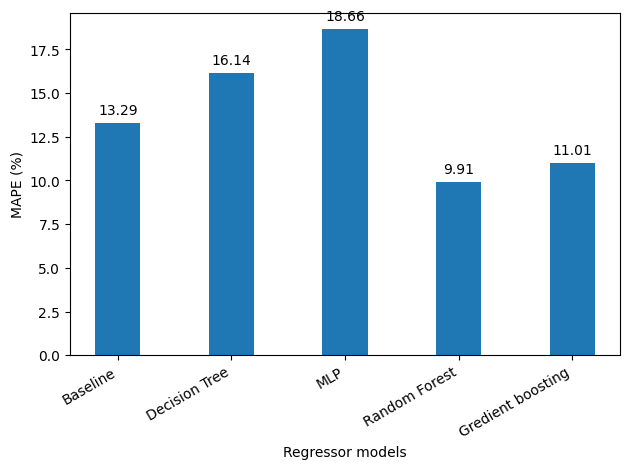

In [28]:
x = ['Baseline', 'Decision Tree', 'MLP', 'Random Forest', 'Gredient boosting']
y = [baseline_mape, dt_mape, mlp_mape, rand_forest_mape, gbr_seq_mape]

fig, ax = plt.subplots()

fig.autofmt_xdate()

ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('MAPE (%)')

for index, value in enumerate(y):
  plt.text(x=index, y=value + 0.5, s=str(value), ha='center')

plt.tight_layout()

# Gala apple data

## Data preprocessing

In [29]:
# เลือกวันที่และ apple พันธุ์ Gala
gala_data = df.loc[:, ['Date', 'Gala']]
# เติมช่องที่ขาดหายไปด้วย interpolation
gala_data = gala_data.interpolate()
# เปลี่ยน format ของ date จาก string เป็น datetime
gala_data['Date'] = pd.to_datetime(gala_data['Date'], format='%d/%m/%Y')
gala_data.sort_values('Date', inplace = True)
gala_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 169 entries, 623 to 3429
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    169 non-null    datetime64[ns]
 1   Gala    169 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.0 KB


C:\Users\NotOte\AppData\Local\Temp\ipykernel_10364\3136669471.py:4: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  gala_data = gala_data.interpolate()


In [30]:
gala_data

,Date,Gala
623,2015-01-04,9817.0
622,2015-01-11,11901.0
621,2015-01-18,15551.0
620,2015-01-25,9611.0
619,2015-02-01,18855.0
...,...,...
3433,2018-02-25,6306.0
3432,2018-03-04,6342.0
3431,2018-03-11,5709.0
3430,2018-03-18,4979.0


## Visualize data

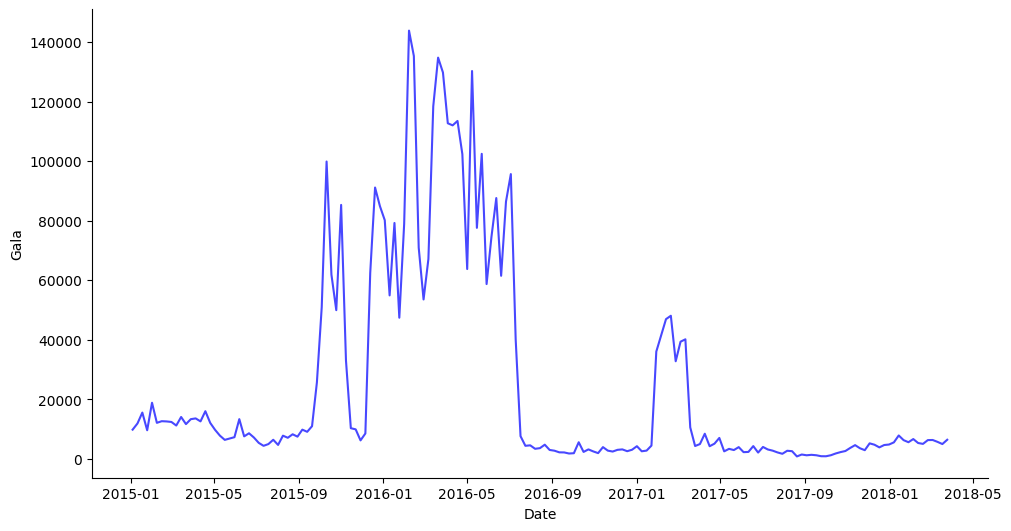

In [31]:
fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = gala_data.sort_values('Date', ascending=True)
_plot_series(df_sorted,'','Gala', 'bwr')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('Gala')

## Predict the next time step using a sequence of past observations

In [32]:
gala = window_input(5, gala_data, 'Gala')
gala

,Date,Gala,x_1,x_2,x_3,x_4,y
623,2015-01-04,9817.0,11901.0,15551.0,9611.0,18855.0,12107.0
622,2015-01-11,11901.0,15551.0,9611.0,18855.0,12107.0,12657.0
621,2015-01-18,15551.0,9611.0,18855.0,12107.0,12657.0,12580.0
620,2015-01-25,9611.0,18855.0,12107.0,12657.0,12580.0,12399.0
619,2015-02-01,18855.0,12107.0,12657.0,12580.0,12399.0,11202.0
...,...,...,...,...,...,...,...
3438,2018-01-21,6292.0,5597.0,6655.0,5327.0,5034.0,6306.0
3437,2018-01-28,5597.0,6655.0,5327.0,5034.0,6306.0,6342.0
3436,2018-02-04,6655.0,5327.0,5034.0,6306.0,6342.0,5709.0
3435,2018-02-11,5327.0,5034.0,6306.0,6342.0,5709.0,4979.0


In [33]:
# X_cols คือ columns ที่มี x_?
X_cols = [col for col in gala.columns if col.startswith('x')]
# เพิ่ม Gala
X_cols.insert(0, 'Gala')

# X = features and y = labels
X = gala[X_cols].values
y = gala['y'].values

# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

In [34]:
# baseline_pred คือ เอาทุก x มาหา mean
baseline_pred = np.array([np.mean(row) for row in X_test])

### Training

#### Decision Tree Regressor

In [35]:
dt_reg = DecisionTreeRegressor(random_state=42, max_depth=3)
dt_reg.fit(X_train, y_train)
dt_pred = dt_reg.predict(X_test)

#### Gredient boosting

In [36]:
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train.ravel())
gbr_pred = gbr.predict(X_test)

#### Random forest

In [37]:
rand_forest_regr = RandomForestRegressor(max_depth=2, random_state=42)
rand_forest_regr.fit(X_train, y_train)
rand_forest_regr_pred = rand_forest_regr.predict(X_test)

#### Multilayer Perceptron (Neural Network)

In [38]:
mlp_regr = MLPRegressor(random_state=1,
                        early_stopping=True,
                        learning_rate_init=0.01).fit(X_train, y_train)
mlp_pred = mlp_regr.predict(X_test)

### Evaluating (MAPE)

In [39]:
baseline_mape = mape(y_test, baseline_pred)
dt_mape = mape(y_test, dt_pred)
gbr_mape = mape(y_test, gbr_pred)
mlp_mape = mape(y_test, mlp_pred)
rand_forest_mape = mape(y_test, rand_forest_regr_pred)

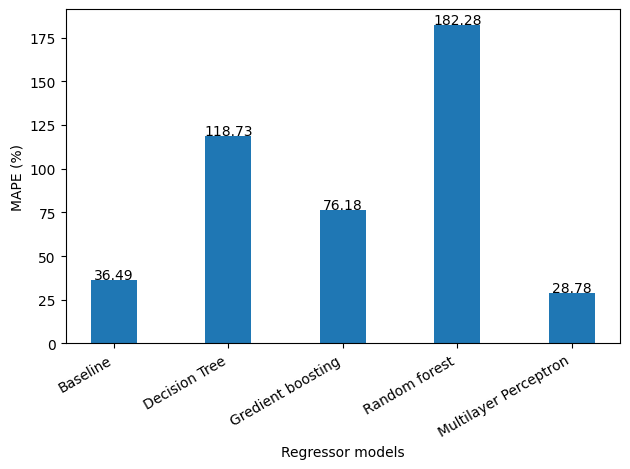

In [40]:
x = ['Baseline', 'Decision Tree', 'Gredient boosting', 'Random forest', 'Multilayer Perceptron']
y = [baseline_mape, dt_mape, gbr_mape, rand_forest_mape, mlp_mape]

fig, ax = plt.subplots()

fig.autofmt_xdate()

ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('MAPE (%)')

for index, value in enumerate(y):
  plt.text(x=index, y=value + 0.5, s=str(value), ha='center')

plt.tight_layout()

## Predict a sequence of future time steps using a sequence of past observations

In [41]:
# เติม x, y ใน envi
gala = window_input_output(5, 5, gala_data, 'Gala')

In [42]:
# page 16 let’s first split the data into a training and a test set.

# X_cols คือ columns ที่มี x_?
X_cols = [col for col in envi.columns if col.startswith('x')]
# เพิ่ม Gala
X_cols.insert(0, 'Gala')

# X_cols คือ columns ที่มี y_?
y_cols = [col for col in gala.columns if col.startswith('y')]

# X = features and y = labels
X = gala[X_cols].values
y = gala[y_cols].values

# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

### Training

#### Decision Tree Regressor

In [43]:
dt_reg = DecisionTreeRegressor(random_state=42)
dt_reg.fit(X_train, y_train)
dt_pred = dt_reg.predict(X_test)

#### Gradient boosting (regressor chain)

In [44]:
gbr = GradientBoostingRegressor(random_state=42)
chained_gbr = RegressorChain(gbr)
chained_gbr.fit(X_train, y_train)
gbr_seq_preds = chained_gbr.predict(X_test)

#### Multilayer Perceptron (Neural Network)

In [45]:
mlp_regr = MLPRegressor(random_state=1, max_iter=1000, solver='adam', early_stopping=True, learning_rate_init=0.01).fit(X_train, y_train)
mlp_pred = mlp_regr.predict(X_test)

#### Random forest

In [46]:
rand_forest_regr = RandomForestRegressor(max_depth=5, random_state=42)
rand_forest_regr.fit(X_train, y_train)
rand_forest_regr_pred = rand_forest_regr.predict(X_test)

### Evaluating (MAPE)

In [47]:
baseline_mape = mape(X_test.reshape(1, -1), y_test.reshape(1, -1))
dt_mape = mape(y_test.reshape(1, -1), dt_pred.reshape(1, -1))
mlp_mape = mape(y_test.reshape(1, -1), mlp_pred.reshape(1, -1))
rand_forest_mape = mape(y_test.reshape(1, -1), rand_forest_regr_pred.reshape(1, -1))
gbr_seq_mape = mape(y_test.reshape(1, -1), gbr_seq_preds.reshape(1, -1))

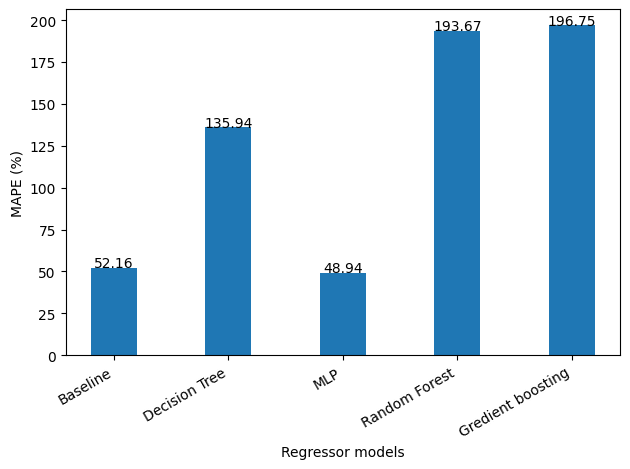

In [48]:
x = ['Baseline', 'Decision Tree', 'MLP', 'Random Forest', 'Gredient boosting']
y = [baseline_mape, dt_mape, mlp_mape, rand_forest_mape, gbr_seq_mape]

fig, ax = plt.subplots()

fig.autofmt_xdate()

ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('MAPE (%)')

for index, value in enumerate(y):
  plt.text(x=index, y=value + 0.5, s=str(value), ha='center')

plt.tight_layout()

# Fuji apple data

## Data preprocessing

In [49]:
# เลือกวันที่และ apple พันธุ์ Fuji
fuji_data = df.loc[:, ['Date', 'Fuji']]
# เติมช่องที่ขาดหายไปด้วย interpolation
fuji_data = fuji_data.interpolate()
# เปลี่ยน format ของ date จาก string เป็น datetime
fuji_data['Date'] = pd.to_datetime(fuji_data['Date'], format='%d/%m/%Y')
fuji_data.sort_values('Date', inplace = True)
fuji_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 169 entries, 623 to 3429
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    169 non-null    datetime64[ns]
 1   Fuji    169 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.0 KB


C:\Users\NotOte\AppData\Local\Temp\ipykernel_10364\1400357898.py:4: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  fuji_data = fuji_data.interpolate()


In [50]:
fuji_data

,Date,Fuji
623,2015-01-04,374421.0
622,2015-01-11,348535.0
621,2015-01-18,374231.0
620,2015-01-25,434746.5
619,2015-02-01,495262.0
...,...,...
3433,2018-02-25,231112.0
3432,2018-03-04,263895.0
3431,2018-03-11,213463.0
3430,2018-03-18,247600.0


## Visualize data

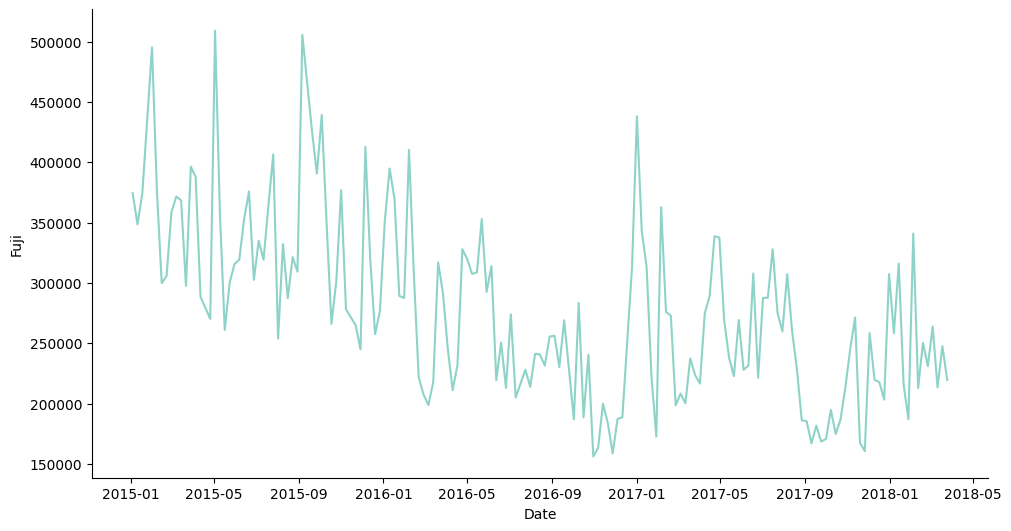

In [51]:
fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = fuji_data.sort_values('Date', ascending=True)
_plot_series(df_sorted,'','Fuji', 'Set3')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('Fuji')

## Predict the next time step using a sequence of past observations

In [52]:
fuji = window_input(5, fuji_data, 'Fuji')
fuji

,Date,Fuji,x_1,x_2,x_3,x_4,y
623,2015-01-04,374421.0,348535.0,374231.0,434746.5,495262.0,376914.0
622,2015-01-11,348535.0,374231.0,434746.5,495262.0,376914.0,299799.0
621,2015-01-18,374231.0,434746.5,495262.0,376914.0,299799.0,305789.0
620,2015-01-25,434746.5,495262.0,376914.0,299799.0,305789.0,358628.0
619,2015-02-01,495262.0,376914.0,299799.0,305789.0,358628.0,371564.0
...,...,...,...,...,...,...,...
3438,2018-01-21,216212.0,187034.0,340887.0,212946.0,250380.0,231112.0
3437,2018-01-28,187034.0,340887.0,212946.0,250380.0,231112.0,263895.0
3436,2018-02-04,340887.0,212946.0,250380.0,231112.0,263895.0,213463.0
3435,2018-02-11,212946.0,250380.0,231112.0,263895.0,213463.0,247600.0


In [53]:
# X_cols คือ columns ที่มี x_?
X_cols = [col for col in fuji.columns if col.startswith('x')]
# เพิ่ม Fuji
X_cols.insert(0, 'Fuji')

# X = features and y = labels
X = fuji[X_cols].values
y = fuji['y'].values

# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

In [54]:
# baseline_pred คือ เอาทุก x มาหา mean
baseline_pred = np.array([np.mean(row) for row in X_test])

### Training

#### Decision Tree Regressor

In [55]:
dt_reg = DecisionTreeRegressor(random_state=42, max_depth=3)
dt_reg.fit(X_train, y_train)
dt_pred = dt_reg.predict(X_test)

#### Gredient boosting

In [56]:
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train.ravel())
gbr_pred = gbr.predict(X_test)

#### Random forest

In [57]:
rand_forest_regr = RandomForestRegressor(max_depth=2, random_state=42)
rand_forest_regr.fit(X_train, y_train)
rand_forest_regr_pred = rand_forest_regr.predict(X_test)

#### Multilayer Perceptron (Neural Network)

In [58]:
mlp_regr = MLPRegressor(random_state=1,
                        early_stopping=True,
                        learning_rate_init=0.01).fit(X_train, y_train)
mlp_pred = mlp_regr.predict(X_test)

### Visualize Prediction

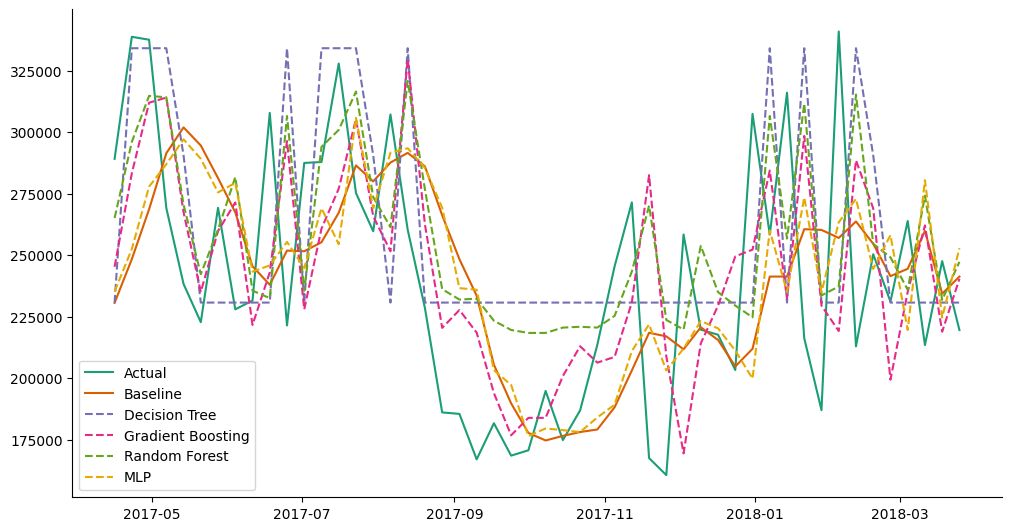

In [59]:
fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')

date = fuji_data['Date'][119:170]

plt.plot(date, y_test, label='Actual', color=list(sns.palettes.mpl_palette('Dark2'))[0])
plt.plot(date, baseline_pred, label='Baseline', color=list(sns.palettes.mpl_palette('Dark2'))[1])
plt.plot(date, dt_pred, label='Decision Tree', linestyle='dashed', color=list(sns.palettes.mpl_palette('Dark2'))[2])
plt.plot(date, gbr_pred, label='Gradient Boosting', linestyle='dashed', color=list(sns.palettes.mpl_palette('Dark2'))[3])
plt.plot(date, rand_forest_regr_pred, label='Random Forest', linestyle='dashed', color=list(sns.palettes.mpl_palette('Dark2'))[4])
plt.plot(date, mlp_pred, label='MLP', linestyle='dashed', color=list(sns.palettes.mpl_palette('Dark2'))[5])
plt.legend()

sns.despine(fig=fig, ax=ax)

### Evaluating (MAPE)

In [60]:
baseline_mape = mape(y_test, baseline_pred)
dt_mape = mape(y_test, dt_pred)
gbr_mape = mape(y_test, gbr_pred)
mlp_mape = mape(y_test, mlp_pred)
rand_forest_mape = mape(y_test, rand_forest_regr_pred)

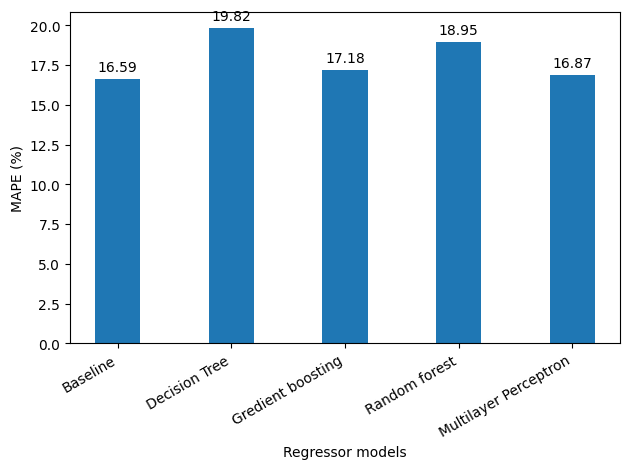

In [61]:
x = ['Baseline', 'Decision Tree', 'Gredient boosting', 'Random forest', 'Multilayer Perceptron']
y = [baseline_mape, dt_mape, gbr_mape, rand_forest_mape, mlp_mape]

fig, ax = plt.subplots()

fig.autofmt_xdate()

ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('MAPE (%)')

for index, value in enumerate(y):
  plt.text(x=index, y=value + 0.5, s=str(value), ha='center')

plt.tight_layout()

## Predict a sequence of future time steps using a sequence of past observations

In [62]:
# เติม x, y ใน fuji
fuji = window_input_output(5, 5, fuji_data, 'Fuji')

In [63]:
# page 16 let’s first split the data into a training and a test set.

# X_cols คือ columns ที่มี x_?
X_cols = [col for col in fuji.columns if col.startswith('x')]
# เพิ่ม Fuji
X_cols.insert(0, 'Fuji')

# X_cols คือ columns ที่มี y_?
y_cols = [col for col in fuji.columns if col.startswith('y')]

# X = features and y = labels
X = fuji[X_cols].values
y = fuji[y_cols].values

# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

### Training

#### Decision Tree Regressor

In [64]:
dt_reg = DecisionTreeRegressor(random_state=42)
dt_reg.fit(X_train, y_train)
dt_pred = dt_reg.predict(X_test)

#### Gradient boosting (regressor chain)

In [65]:
gbr = GradientBoostingRegressor(random_state=42)
chained_gbr = RegressorChain(gbr)
chained_gbr.fit(X_train, y_train)
gbr_seq_preds = chained_gbr.predict(X_test)

#### Multilayer Perceptron (Neural Network)

In [66]:
mlp_regr = MLPRegressor(random_state=1, max_iter=1000, solver='adam', early_stopping=True, learning_rate_init=0.01).fit(X_train, y_train)
mlp_pred = mlp_regr.predict(X_test)

#### Random forest

In [67]:
rand_forest_regr = RandomForestRegressor(max_depth=5, random_state=42)
rand_forest_regr.fit(X_train, y_train)
rand_forest_regr_pred = rand_forest_regr.predict(X_test)

### Evaluating (MAPE)

In [68]:
baseline_mape = mape(X_test.reshape(1, -1), y_test.reshape(1, -1))
dt_mape = mape(y_test.reshape(1, -1), dt_pred.reshape(1, -1))
mlp_mape = mape(y_test.reshape(1, -1), mlp_pred.reshape(1, -1))
rand_forest_mape = mape(y_test.reshape(1, -1), rand_forest_regr_pred.reshape(1, -1))
gbr_seq_mape = mape(y_test.reshape(1, -1), gbr_seq_preds.reshape(1, -1))

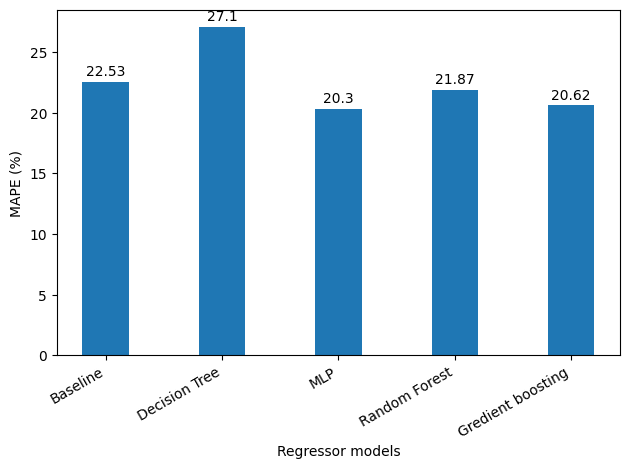

In [69]:
x = ['Baseline', 'Decision Tree', 'MLP', 'Random Forest', 'Gredient boosting']
y = [baseline_mape, dt_mape, mlp_mape, rand_forest_mape, gbr_seq_mape]

fig, ax = plt.subplots()

fig.autofmt_xdate()

ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('MAPE (%)')

for index, value in enumerate(y):
  plt.text(x=index, y=value + 0.5, s=str(value), ha='center')

plt.tight_layout()